In [208]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [263]:
import pandas as pd
import networkx as nx
import numpy as np
import Levenshtein as lev

import matplotlib.pyplot as plt
from arion.utils import generate_db, peakset2ppm, Colors, MetabolitePeak, PeakDB, Colors

In [252]:
data_dir = '/media/shared/arion_data/metabolites'

In [211]:
filled = pd.read_csv('filled.csv').iloc[:, 1:]
features = pd.read_csv('features.csv').iloc[:, 1:]
features.shape

(16, 547)

In [212]:
corr_mat = features.corr('spearman')
top_vals = corr_mat > 0.70

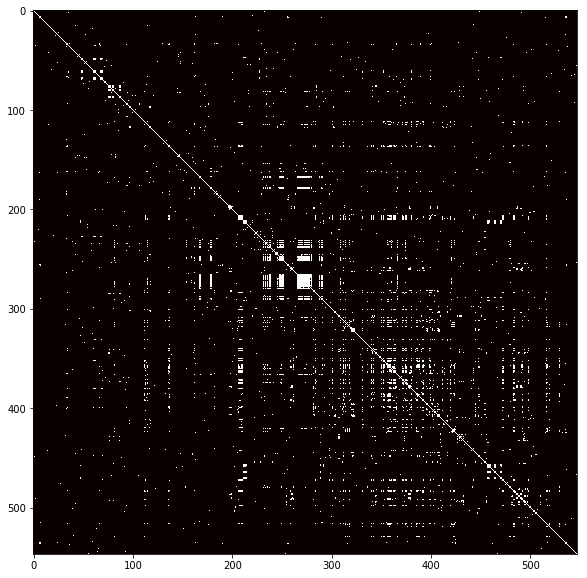

In [213]:
plt.figure(figsize=(10, 10))
plt.imshow(top_vals, cmap='hot', interpolation='none')

In [214]:
g = nx.Graph(np.abs(corr_mat) > 0.60)

In [215]:
cliqs = []

MAXCLIQUES = 100000
for idx, cliq in enumerate(nx.find_cliques(g)):
    if idx > MAXCLIQUES:
        raise Exception(f"More than {MAXCLIQUES} cliques found")
        break
    cliqs.append(cliq)
print(f"found {len(cliqs)} cliques")

found 6534 cliques


In [216]:
peak_db = generate_db(data_dir)

In [74]:
found = False
identified_metabolites = []
for idx, cliq in enumerate(cliqs):
    res = peak_db.query_n(peakset2ppm(cliq, filled), missing_thresh=0.8)
    for qs in res:
        if qs['score'] >= 0.1 and len(peak_db.metabolite_peaks[qs['metabolite_id']]) > 0 and len(qs['missing']) < 2:
            identified_metabolites.append((idx, cliq, qs))

In [23]:
import glob
import xml.etree.ElementTree as ET

data_dir = '/media/shared/arion_data/metabolites'
xml_file = 'simulation_1/spin_simulation.xml'
cutoff = 0.001

peaks = []
met_idx = 0
names = {}
for met_idx, d in enumerate(glob.glob(f'{data_dir}/bmse*')):
    metabolite_id = d.split('/')[-1]

    tree = ET.parse(f'{d}/{xml_file}')
    root = tree.getroot()
    names[root.find('ID').text] = root.find('name').text

In [24]:
import csv

hamid_met_names = []
with open("names_from_hamid.csv") as f:
    csvfile = csv.reader(f)
    next(csvfile)
    for line in csvfile:
        hamid_met_names.append([l.strip() for l in line])

In [25]:
matched_count = 0
unmatched_count = 0

# unmatched_file = open('umatched.csv', 'w')
# writer = csv.writer(unmatched_file)
# writer.writerow([f"Name {i}" for i in range(1, 6)] + [f"suggestion {i}" for i in range(1, 6)])

matched_set = set()
for hamid_met_name_set in hamid_met_names:
    matches = []
    for n in hamid_met_name_set:
        scores = [(n, lev.jaro(n.lower(), m.lower()), (i, m)) for i, m in names.items()]
        matches.append(max(scores, key=lambda a: a[1]))
    
    if any([abs(m[1] - 1) < 0.000001 for m in matches]):
        matched_count += 1
        maxv = max(matches, key=lambda a: a[1])
#         print(maxv)
        matched_set.add(maxv[2][0])
    else:
        orig = [i[0] for i in matches]
        suggestions = [f'{i[2][1]} <{i[2][0]}>' for i in matches]
        
#         writer.writerow(orig + suggestions)
        
        unmatched_count += 1
print(f"matched {matched_count} | unmatched {unmatched_count}")

matched_set.update(['bmse000208', 'bmse000161', 'bmse000373', 'bmse000092', 'bmse000142', 'bmse000182'])
# unmatched_file.close()

matched 68 | unmatched 46


In [27]:
unique_metabolites = {i[2]['metabolite_id'] for i in identified_metabolites}
print(f'identified {len(unique_metabolites)} potential metabolites')
matched_cnt = 0

final_res = []
for m in unique_metabolites:
    if m in matched_set:
        final_res.append((m, names[m]))
        matched_cnt += 1
        print(f"  {m}({len(peak_db.metabolite_peaks[m])})", Colors.color(f"found - {names[m]}", Colors.OKGREEN) if m in matched_set else Colors.color("not found", Colors.FAIL))
print(f'{matched_cnt} metabolites were acceptable')

identified 93 potential metabolites
  bmse000160(2) found - Sarcosine
  bmse000426(1) found - Trimethylamine N-oxide
  bmse000191(1) found - Acetic acid
  bmse000076(4) found - Citrate
  bmse000155(2) found - Creatinine
  bmse000028(6) found - L-Alanine
  bmse000127(1) found - Xanthine
  bmse000112(1) found - Pyruvic acid
  bmse000069(2) found - Betaine
  bmse000863(7) found - Taurine
  bmse000089(1) found - Glycine
  bmse000078(4) found - Creatine
  bmse000208(6) found - L-(+) Lactic acid
  bmse000206(4) found - Caffeine
  bmse000294(1) found - Methanol
  bmse000083(1) found - Fumaric acid
  bmse000161(16) found - 3-Hydroxybutyrate
  bmse000183(1) found - Succinic acid
18 metabolites were acceptable


In [28]:
raw_day0 = pd.read_csv('../data/source_data/AVM_day0_spectra.csv', delimiter='\t').iloc[:, :-1]

In [253]:
def peakset2ppm_v(peakset, filled):
    subsets = [filled.loc[filled.peakIndex == int(vtx), :] for vtx in peakset]
    return [(a.peakPPM.mean(), a.peakValue.mean()) for a in subsets]

In [277]:
peak_file = 'simulation_1/peaks/sim_600MHz_peaks_standard.csv'
cutoff = 0.001

peaks = []
met_idx = 0
for met_idx, d in enumerate(glob.glob(f'{data_dir}/bmse*')):
    metabolite_id = d.split('/')[-1]
    peak_df = pd.read_csv(f'{d}/{peak_file}')

    for idx, peak in peak_df.iterrows():
        if peak['Amp'] >= cutoff:
            peaks.append(MetabolitePeak(metabolite_id, peak['PPM'], peak['Amp']))

met_peak_db = PeakDB(peaks)

peaks = []
for peak in peakset2ppm_v(features.columns.values, filled):
    peaks.append(MetabolitePeak('user', peak[0], peak[1]))

user_peak_db = PeakDB(peaks)

In [293]:
i = 0
j = 0
for met_id, met_peaks in met_peak_db.metabolite_peaks.items():
# for met_id in matched_set:
    met_peaks = met_peak_db.metabolite_peaks[met_id]
    
    missed = 0
        
    for met_peak in met_peaks:
#         print(met_peak)
        found_match = False
        res = user_peak_db.query_peak(met_peak.ppm)
        for matched_peak in res:
            if matched_peak.id.startswith('user'):
                found_match = True
#                 print(matched_peak)
        if not found_match:
            missed += 1
    
    if missed > 1:
        print(Colors.color(f'{met_id} -- missed {missed}/{len(met_peaks)}', Colors.FAIL))
    else:
        print(Colors.color(f'{met_id} -- missed {missed}/{len(met_peaks)}', Colors.OKGREEN))
        i += 1
        
    j += 1
print(f'{i}/{j} metabolites found')

bmse000030 -- missed 0/12
bmse000031 -- missed 0/12
bmse000032 -- missed 3/59
bmse000033 -- missed 4/36
bmse000034 -- missed 1/11
bmse000035 -- missed 3/12
bmse000037 -- missed 0/37
bmse000038 -- missed 0/22
bmse000039 -- missed 0/14
bmse000040 -- missed 0/26
bmse000041 -- missed 5/48
bmse000042 -- missed 0/25
bmse000043 -- missed 3/61
bmse000044 -- missed 1/21
bmse000045 -- missed 0/20
bmse000046 -- missed 0/12
bmse000047 -- missed 2/48
bmse000048 -- missed 0/12
bmse000049 -- missed 0/10
bmse000288 -- missed 2/4
bmse000290 -- missed 2/9
bmse000291 -- missed 0/28
bmse000293 -- missed 0/1
bmse000294 -- missed 0/1
bmse000297 -- missed 0/7
bmse000299 -- missed 2/33
bmse000300 -- missed 1/8
bmse000302 -- missed 4/20
bmse000303 -- missed 1/14
bmse000304 -- missed 0/1
bmse000305 -- missed 3/21
bmse000307 -- missed 6/25
bmse000308 -- missed 1/10
bmse000309 -- missed 0/11
bmse000310 -- missed 5/18
bmse000311 -- missed 6/29
bmse000312 -- missed 3/7
bmse000316 -- missed 10/20
bmse000318 -- misse

In [248]:
peak

8.749345555555557

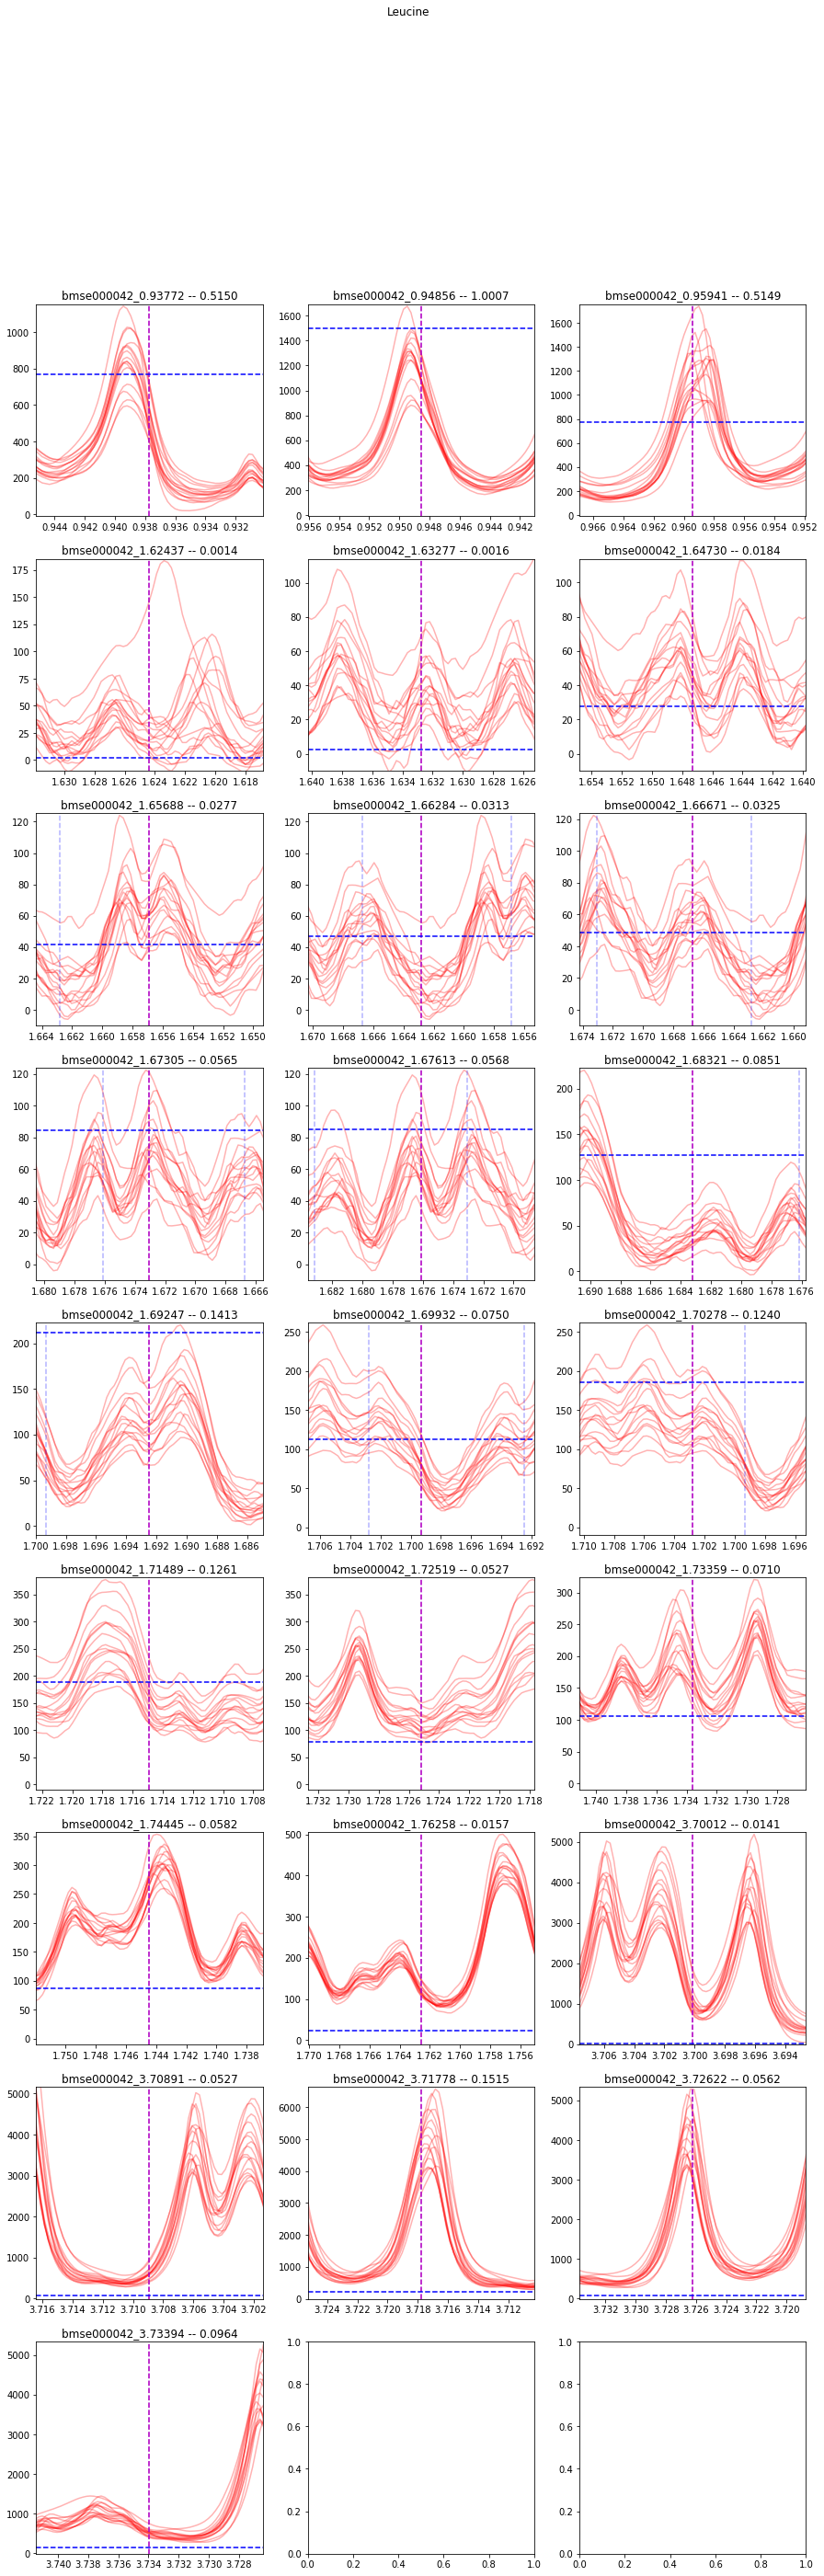

In [48]:
# identify a max amplitude value
width = 0.0075
same_ymax = False
# width = 0.1

# for found_met in final_res:
for found_met in [('bmse000042', 'Leucine')]:
    met_peaks = peak_db.metabolite_peaks[found_met[0]]
    
    if len(met_peaks) < 5:
        continue
    
    peak_max = max(met_peaks, key=lambda x: x.amp).ppm
    idx1 = np.abs(raw_day0.iloc[:, 0] - peak_max + 0.0075).idxmin()
    idx2 = np.abs(raw_day0.iloc[:, 0] - peak_max - 0.0075).idxmin()
    
    # average of top 20 peaks is our estimate of max_amp
    max_amp = raw_day0.iloc[idx1:idx2].values.flatten()[raw_day0.iloc[idx1:idx2].values.flatten().argsort()[::-1][:15]].mean()

    s = len(met_peaks)
    rows = s // 3
    rows = rows if s % 3 == 0 else rows + 1

    f, axl = plt.subplots(nrows=rows, ncols=3, figsize=(15, 5 * rows))
    f.suptitle(found_met[1])

    overall_ymax = 0
    for i, peak in enumerate(met_peaks):
        ax = axl.flatten()[i]
        center = peak.ppm

        ax.plot(raw_day0.iloc[:, 0][::-1], raw_day0.iloc[:, 1:][::-1], 'r', alpha=0.3);
        
        for m in met_peaks:
            ax.axvline(x=m.ppm, linestyle='--', color='b', alpha=0.3)
        ax.axvline(x=center, linestyle='--', color='m')
        
        ax.axhline(y=peak.amp * max_amp, linestyle='--', color='b')

        ax.set_title(f'{peak.id} -- {peak.amp:.4f}')
        ax.set_xlim(center + width, center - width)

        idx1 = np.abs(raw_day0.iloc[:, 0] - center + width).idxmin()
        idx2 = np.abs(raw_day0.iloc[:, 0] - center - width).idxmin()
        ymax = raw_day0.iloc[idx1:idx2].values.max() * 1.01

        if ymax > overall_ymax:
            overall_ymax = ymax
        ax.set_ylim(-10, ymax)

    if same_ymax:
        for i, peak in enumerate(met_peaks):
            ax = axl.flatten()[i]
            ax.set_ylim(-10, overall_ymax)
    
    break

In [128]:
filled.loc[(filled.peakPPM > c - w) & (filled.peakPPM < c + w)]

,peakIndex,peakPPM,peakValue,peakSNR,peakScale,Sample
6419,48471,0.959252,2018.955974,18.111996,10.0,1
6420,48471,0.958518,2545.782848,25.689877,10.5,2
6421,48471,0.959007,2614.557572,21.054263,10.0,3
6422,48471,0.959252,2757.392248,28.249590,9.5,4
6423,48471,0.958274,2952.798025,23.899132,10.5,5
6424,48471,0.958518,2557.786991,22.703708,10.5,6
6425,48471,0.958274,1869.574287,23.159166,10.0,7
6426,48471,0.958029,2425.771869,18.915524,10.5,8
6427,48471,0.959007,3158.716221,20.367902,10.0,9
6428,48471,0.958518,3001.233869,26.253480,10.0,10


In [286]:
c = 0.94856
w = 0.0075
a = filled.loc[(filled.peakPPM > c - w) & (filled.peakPPM < c + w)]['peakSNR'].values

In [287]:
c = 0.95941
w = 0.0075
b = filled.loc[(filled.peakPPM > c - w) & (filled.peakPPM < c + w)]['peakSNR'].values

In [288]:
s.spearmanr(a,b)

SpearmanrResult(correlation=-0.2764705882352941, pvalue=0.2999421284923735)

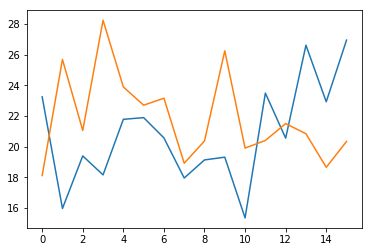

In [139]:
plt.plot(np.array([a, b]).T);

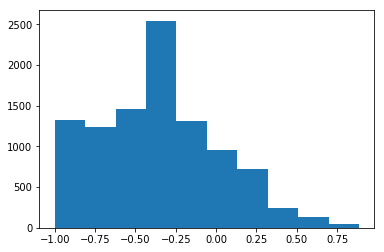

In [206]:
allv = []
for i in range(10000):
    v = features.loc[np.random.choice(16, 6, replace=False), ('37191', '48510')].corr('spearman').iloc[0, 1]
    allv.append(v)
plt.hist(allv);

In [195]:
np.random.choice(16, 16)

array([13,  6, 13,  3,  2, 12,  5,  6, 13, 13, 11,  6,  8,  5,  2,  8])

In [156]:
features.loc[[13, 11,  6, 10,  1, 12], ('48471', '48510')]

,48471,48510
13,1901.115086,2428.420582
11,2294.897919,2642.690705
6,1869.574287,1660.424690
10,2523.894198,1945.909404
1,2545.782848,1581.764423
12,2396.325388,2290.257986


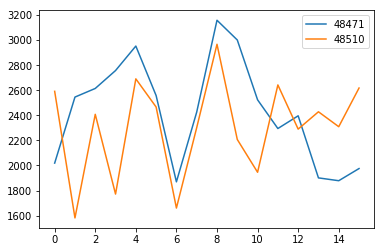

In [140]:
features.loc[:, ('48471', '48510')].plot()

In [111]:
a = features.loc[:, ('48471', '48510', '37191')]

In [114]:
p484, p485 = a.iloc[:, 1].values, a.iloc[:, 2].values

In [115]:
import scipy.stats as s

s.kendalltau(p484, p485)

KendalltauResult(correlation=-0.3, pvalue=0.10505826276004727)

In [90]:
mega_click = []
for c in cliqs:
    if '48510' in c:
        mega_click += c

In [91]:
mega_cliq = np.unique(mega_click).tolist()
qs = peak_db.query_n(peakset2ppm(mega_click, filled), missing_thresh=0.8)
qs_f = list(filter(lambda x: x['metabolite_id'] == 'bmse000042', qs))
qs_f

[{'metabolite_id': 'bmse000042',
  'matches': {'l_1.68186': 'bmse000042_1.67613',
   'l_1.67289': 'bmse000042_1.66671',
   'l_1.69036': 'bmse000042_1.68321',
   'l_0.93922': 'bmse000042_0.93772',
   'l_0.94926': 'bmse000042_0.94856',
   'l_1.71733': 'bmse000042_1.71489',
   'l_1.73464': 'bmse000042_1.73359',
   'l_1.65757': 'bmse000042_1.66284',
   'l_1.74349': 'bmse000042_1.74445'},
  'score': 0.36,
  'missing': ['bmse000042_0.95941',
   'bmse000042_1.65688',
   'bmse000042_1.67305',
   'bmse000042_1.69247',
   'bmse000042_1.69932',
   'bmse000042_1.70278',
   'bmse000042_1.72519',
   'bmse000042_3.70891',
   'bmse000042_3.71778',
   'bmse000042_3.72622',
   'bmse000042_3.73394']}]

In [78]:
for c in cliqs:
    if '48510' in c:
        qs = peak_db.query_n(peakset2ppm(c, filled), missing_thresh=0.8)
        qs_f = list(filter(lambda x: x['metabolite_id'] == 'bmse000042', qs))
        print(len(c), len(qs_f[0]['matches']))
        print(c, qs_f)
        print("-----------------")

10 4
['22331', '45551', '48651', '48551', '48333', '48600', '48285', '48510', '45479', '21019'] [{'metabolite_id': 'bmse000042', 'matches': {'l_1.67289': 'bmse000042_1.66671', 'l_0.93922': 'bmse000042_0.93772', 'l_0.94926': 'bmse000042_0.94856', 'l_1.69036': 'bmse000042_1.68321'}, 'score': 0.16, 'missing': ['bmse000042_0.95941', 'bmse000042_1.65688', 'bmse000042_1.66284', 'bmse000042_1.67305', 'bmse000042_1.67613', 'bmse000042_1.69247', 'bmse000042_1.69932', 'bmse000042_1.70278', 'bmse000042_1.71489', 'bmse000042_1.72519', 'bmse000042_1.73359', 'bmse000042_1.74445', 'bmse000042_3.70891', 'bmse000042_3.71778', 'bmse000042_3.72622', 'bmse000042_3.73394']}]
-----------------
10 4
['22331', '45551', '48651', '48551', '48333', '48600', '48285', '48510', '45479', '41739'] [{'metabolite_id': 'bmse000042', 'matches': {'l_1.67289': 'bmse000042_1.66671', 'l_0.93922': 'bmse000042_0.93772', 'l_0.94926': 'bmse000042_0.94856', 'l_1.69036': 'bmse000042_1.68321'}, 'score': 0.16, 'missing': ['bmse00004

In [57]:
qs_f

[{'metabolite_id': 'bmse000042',
  'matches': {'l_1.73464': 'bmse000042_1.73359',
   'l_0.94926': 'bmse000042_0.94856',
   'l_1.68186': 'bmse000042_1.67613'},
  'score': 0.12,
  'missing': ['bmse000042_0.93772',
   'bmse000042_0.95941',
   'bmse000042_1.67305',
   'bmse000042_1.68321',
   'bmse000042_1.69247',
   'bmse000042_1.69932',
   'bmse000042_1.70278',
   'bmse000042_1.71489',
   'bmse000042_1.72519',
   'bmse000042_1.74445',
   'bmse000042_3.70891',
   'bmse000042_3.71778',
   'bmse000042_3.72622',
   'bmse000042_3.73394']}]

In [47]:
met_peaks

[<Peak id:bmse000042_0.93772 metabolite_id:bmse000042 ppm:0.93772 amplitude:0.51500>,
 <Peak id:bmse000042_0.94856 metabolite_id:bmse000042 ppm:0.94856 amplitude:1.00074>,
 <Peak id:bmse000042_0.95941 metabolite_id:bmse000042 ppm:0.95941 amplitude:0.51485>,
 <Peak id:bmse000042_1.62437 metabolite_id:bmse000042 ppm:1.62437 amplitude:0.00145>,
 <Peak id:bmse000042_1.63277 metabolite_id:bmse000042 ppm:1.63277 amplitude:0.00159>,
 <Peak id:bmse000042_1.64730 metabolite_id:bmse000042 ppm:1.64730 amplitude:0.01839>,
 <Peak id:bmse000042_1.65688 metabolite_id:bmse000042 ppm:1.65688 amplitude:0.02767>,
 <Peak id:bmse000042_1.66284 metabolite_id:bmse000042 ppm:1.66284 amplitude:0.03134>,
 <Peak id:bmse000042_1.66671 metabolite_id:bmse000042 ppm:1.66671 amplitude:0.03247>,
 <Peak id:bmse000042_1.67305 metabolite_id:bmse000042 ppm:1.67305 amplitude:0.05649>,
 <Peak id:bmse000042_1.67613 metabolite_id:bmse000042 ppm:1.67613 amplitude:0.05681>,
 <Peak id:bmse000042_1.68321 metabolite_id:bmse000042 

## Playground

In [37]:
final_res

[('bmse000160', 'Sarcosine'),
 ('bmse000426', 'Trimethylamine N-oxide'),
 ('bmse000191', 'Acetic acid'),
 ('bmse000076', 'Citrate'),
 ('bmse000155', 'Creatinine'),
 ('bmse000028', 'L-Alanine'),
 ('bmse000127', 'Xanthine'),
 ('bmse000112', 'Pyruvic acid'),
 ('bmse000069', 'Betaine'),
 ('bmse000863', 'Taurine'),
 ('bmse000089', 'Glycine'),
 ('bmse000078', 'Creatine'),
 ('bmse000208', 'L-(+) Lactic acid'),
 ('bmse000206', 'Caffeine'),
 ('bmse000294', 'Methanol'),
 ('bmse000083', 'Fumaric acid'),
 ('bmse000161', '3-Hydroxybutyrate'),
 ('bmse000183', 'Succinic acid')]

In [23]:
filled[np.logical_and(filled.peakPPM > 3.09, filled.peakPPM < 3.10)]

,peakIndex,peakPPM,peakValue,peakSNR,peakScale,Sample
2932,39724,3.09768,1645.851751,78.810757,16.0,1
2933,39724,3.09768,1668.194836,16.073119,16.0,2
2934,39724,3.09768,1353.187492,27.515097,16.0,4
2935,39724,3.09768,1442.829691,21.724018,16.0,5
2936,39724,3.09792,799.588237,13.440489,16.0,6
2937,39724,3.09768,1048.566347,25.428368,16.0,7
2938,39724,3.09792,1099.928058,41.239464,15.0,8
2939,39724,3.09792,2318.607778,36.745645,16.0,9
2940,39724,3.09792,1144.814369,29.424182,16.0,10
2941,39724,3.09792,1526.418191,25.952690,16.0,11
